# Guerlédan 2024/02: seabot

To do:

- compute averaged spectra
- add transfer function estimates and leverage for interpretation spectral analysis (relative displacement vs isopycnal displacement ratio)
- reconstruct dynamics (use float library), estimate $V_{air}$
- do we need to look at other deployments?
- `test_guerledan_2024_02_09/night/seabot5/rosbag2_2024_02_08-21_00_48/data/observer/temperature.npz` is empty
- animate float behavior for illustration purposes
- compare measured depth with that interpolated from the bathymetric map and an estimate of the position - road to horizontal position assessment

Question: par quoi la variabilité de température est-elle contrôlée? Hypothèse: capteur, bruit haute fréquence (vérifier )

To improve in future deployments:

- collect independent GPS fixes at deployments/recoveries
- avoid corrupted GPS data streams
- vertical profile missions are not continuously ascending and descending which complicates having consistent clean vertical profile of hydrology
- did not find distance to seafloor from echosounder ... could be useful to constraint trajectories


In [1]:
import os
from glob import glob

import xarray as xr
import pandas as pd
import numpy as np

#%matplotlib inline
import matplotlib.pyplot as plt
plt.rc('figure', titlesize=10)
plt.rc('axes', titlesize=10)
import hvplot.pandas # noqa
from cmocean import cm

import pynsitu as pin
import cognac.ufloat as fl
import seabot as sb
crs = sb.crs

show_hv=False

In [2]:
#root_path = "/Users/aponte/Current_Projects/ensta/guerledan_202310/data_seabot"
root_dir = "/Users/aponte/Current_Projects/ensta/guerledan/"

seabot_dir = os.path.join(root_dir, "202402/data_raw/data_seabot")
D = sb.walk_load_repo(seabot_dir)

cp = pin.Campaign("guerledan_202402.yaml")
M = sb.match_dict_cp(D, cp)

2024_02_05-20_06_37
2024_02_05-20_06_54
2024_02_06-15_11_30
2024_02_06-15_08_44
multiple rosbags encountered in /Users/aponte/Current_Projects/ensta/guerledan/202402/data_raw/data_seabot/test_guerledan_2024_02_06/test_emission_inter_flotteur/seabot1
2024_02_06-16_25_01
2024_02_06-16_57_08
2024_02_06-16_25_28
2024_02_06-17_20_16
2024_02_06-17_20_31
2024_02_07-15_37_15
2024_02_07-15_37_16
2024_02_09-11_04_43
2024_02_08-21_00_52
2024_02_08-21_00_48


In [3]:
# used to fill yaml file
#Dk = sb.dfilter(D, "observer_kalman")
#sb.pprint(Dk)

In [4]:
#list(D)

In [5]:
# extract relevant data sets
Dk = sb.dfilter(D, "observer_kalman")
Dd = sb.dfilter(D, "observer_depth")
#Dpiston = sb.dfilter(D, "driver_piston")

colors = {d: c for d, c in zip(list(Dk), pin.get_cmap_colors(len(Dk)))}

# combine temperature and kalman data
Dc = sb.combine(
    D, "1s", 
    ka="observer_kalman", 
    te="observer_temperature", 
    pi="driver_piston",
    de="observer_depth",
)
# add/massage variables
for d, df in Dc.items():
    # append depth filtered to match temperature
    sb.append_depth_filtered(df, 2., key="ka_depth")
    # append piston displacement and volume
    df["pi_course"], df["pi_volume"] = sb.position2course(df["pi_position"])

# inspect if need be:
#df["depth"].hvplot() * df["depth_filtered"].hvplot()    

#### show sampling rates

In [6]:
#sb.pprint(D)

In [7]:
def show_sampling_rate(D):
    keys = ["_".join(d) for d in list(D)]
    data = []
    for d, df in D.items():
        dt = df["time_since_start"].diff()/pd.Timedelta("1s")
        data.append(np.mean(dt))
    return pd.Series(data, index=keys)

for label in ["observer_kalman", "observer_temperature"]:
    _D = sb.dfilter(D, label)
    s = show_sampling_rate(_D)
    print(f"-- {label}, dt (s):")
    print(s)

-- observer_kalman, dt (s):
test_guerledan_2024_02_05_seabot4                                                             0.200005
test_guerledan_2024_02_05_seabot5                                                             0.199855
test_guerledan_2024_02_06_test_15m_seabot1                                                    0.200002
test_guerledan_2024_02_06_test_15m_seabot3                                                    0.199999
test_guerledan_2024_02_06_test_emission_inter_flotteur_seabot1_rosbag2_2024_02_06-16_25_01    0.199997
test_guerledan_2024_02_06_test_emission_inter_flotteur_seabot1_rosbag2_2024_02_06-16_57_08    0.200015
test_guerledan_2024_02_06_test_emission_inter_flotteur_seabot3                                0.200009
test_guerledan_2024_02_07_night_seabot4                                                       0.200003
test_guerledan_2024_02_07_night_seabot5                                                       0.200001
test_guerledan_2024_02_08_night_seabot4      

#### show positions

In [8]:
#Dpos = dfilter(Df, 'driver_fix')
Dpos = sb.dfilter(D, 'driver_fix')
sb.pprint(Dpos)

test_guerledan_2024_02_05 / seabot4 2024/02/05 20:06:44 to 2024/02/05 20:50:17
test_guerledan_2024_02_05 / seabot5 2024/02/05 20:06:57 to 2024/02/05 20:50:09
test_guerledan_2024_02_06 / test_15m / seabot1 2024/02/06 15:11:40 to 2024/02/06 15:37:41
test_guerledan_2024_02_06 / test_15m / seabot3 2024/02/06 15:08:44 to 2024/02/06 15:37:44
test_guerledan_2024_02_06 / test_emission_inter_flotteur / seabot1 / rosbag2_2024_02_06-16_25_01 2024/02/06 16:25:01 to 2024/02/06 16:45:17
test_guerledan_2024_02_06 / test_emission_inter_flotteur / seabot1 / rosbag2_2024_02_06-16_57_08 2024/02/06 16:57:09 to 2024/02/06 17:33:15
test_guerledan_2024_02_06 / test_emission_inter_flotteur / seabot3 2024/02/06 16:25:35 to 2024/02/06 17:26:17
test_guerledan_2024_02_07 / night / seabot4 2024/02/06 17:20:19 to 2024/02/07 08:45:09
test_guerledan_2024_02_07 / night / seabot5 2024/02/06 17:20:34 to 2024/02/07 08:45:35
test_guerledan_2024_02_08 / night / seabot4 2024/02/07 15:37:15 to 2024/02/08 08:53:01
test_guerle

Some of the GPS data is crazy (2024_02_07 and seabot 5)

In [9]:
#show_gps(Dpos, 0, True)
#show_gps(Dpos, 0, False)
#show_gps(Dpos, 9, None, full=True)

In [10]:
# manually select good gps times
if cp["name"]=="guerledan_202402":
    # these are pushed in yaml file and that's the source that should be used
    deployments = {
        ('test_guerledan_2024_02_07', 'night', 'seabot5'): dict(start=pd.Timestamp("2024/02/06 17:26:32"), end=pd.Timestamp("2024/02/07 08:32:00") ),
        ('test_guerledan_2024_02_07', 'night', 'seabot4'): dict(start=pd.Timestamp("2024/02/06 17:30:25"), end=pd.Timestamp("2024/02/07 08:32:00") ),
        ('test_guerledan_2024_02_08', 'night', 'seabot5'): dict(start=pd.Timestamp("2024/02/07 15:50:40"), end=pd.Timestamp("2024/02/08 08:33:00") ),
        ('test_guerledan_2024_02_08', 'night', 'seabot4'): dict(start=pd.Timestamp("2024/02/07 15:50:45"), end=pd.Timestamp("2024/02/08 08:33:00") ),
        ('test_guerledan_2024_02_09', 'night', 'seabot5'): dict(start=pd.Timestamp("2024/02/08 21:12:18"), end=pd.Timestamp("2024/02/09 08:04:00") ),
        ('test_guerledan_2024_02_09', 'night', 'seabot4'): dict(start=pd.Timestamp("2024/02/08 21:12:12"), end=pd.Timestamp("2024/02/09 08:06:30") ),
    }
    blank = [('test_guerledan_2024_02_07', 'night', 'seabot5'), ('test_guerledan_2024_02_07', 'night', 'seabot4')]
sb.load_gps(deployments, Dpos) # inplace

# mask bad gps data
for b in blank:
    for k in ["start_lon", "start_lat", "end_lon", "end_lat"]:
        deployments[b][k] = None

# show
#deployments

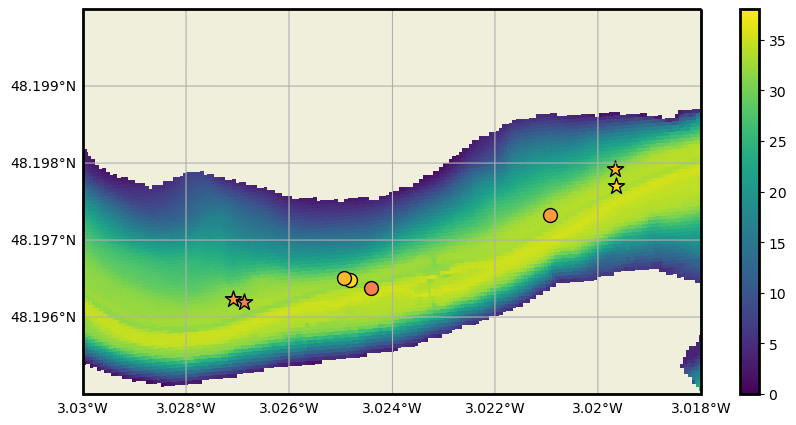

In [11]:
mapkw = dict(
    figsize=(10,5),
    extent=[-3.03, -3.018, 48.195, 48.2],
    tile=False,
    #tile_level=16,
    bathy=cp["bathy"]["path"], 
)
fig, ax = sb.plot_map(**mapkw)

for d, info in deployments.items():
    c = colors[d]
    ax.scatter(info["start_lon"], info["start_lat"], s=100, c=c, marker="o", edgecolor="k", transform=crs)
    ax.scatter(info["end_lon"], info["end_lat"], s=150, c=c, marker="*", edgecolor="k", transform=crs) #, edgecolor="k")

**WARNING**

('test_guerledan_2024_02_08', 'seabot5') never aquired a good GPS fix at start up

Make sure GPS position is collected next times

We override with ('test_guerledan_2024_02_08', 'seabot4') start position plus a small (3m) offset

In [12]:
if cp["name"]=="guerledan_202402":
    for k in ["start_lon", "start_lat"]:
        deployments[('test_guerledan_2024_02_08', 'night', 'seabot5')][k] = \
            deployments[('test_guerledan_2024_02_08', 'night', 'seabot4')][k] + 3e-5

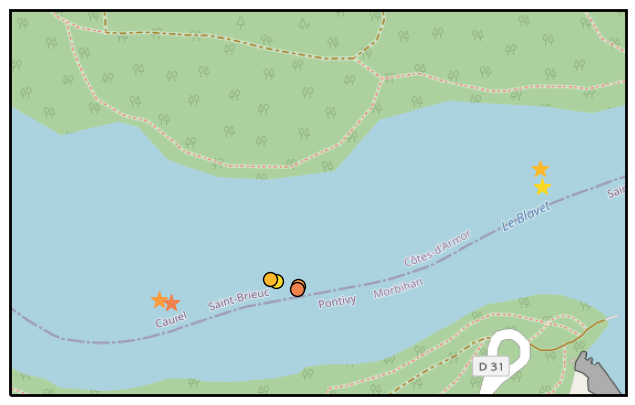

In [13]:
mapkw = dict(
    figsize=(10,5),
    extent=[-3.03, -3.018, 48.195, 48.2],
    tile_level=16,
)
fig, ax = sb.plot_map(**mapkw)

for d, info in deployments.items():
    c = colors[d]
    #print(info["start_lon"], info["start_lat"])
    #print(info["end_lon"], info["end_lat"])
    ax.scatter(info["start_lon"], info["start_lat"], s=100, c=c, marker="o", edgecolor="k", transform=crs)
    ax.scatter(info["end_lon"], info["end_lat"], s=150, c=c, marker="*", transform=crs) #, edgecolor="k")

In [14]:
#D[('test_guerledan_2024_02_05', 'seabot4', 'safety_safety')]


### overview of all dives

(<Figure size 1500x400 with 1 Axes>, <Axes: >)

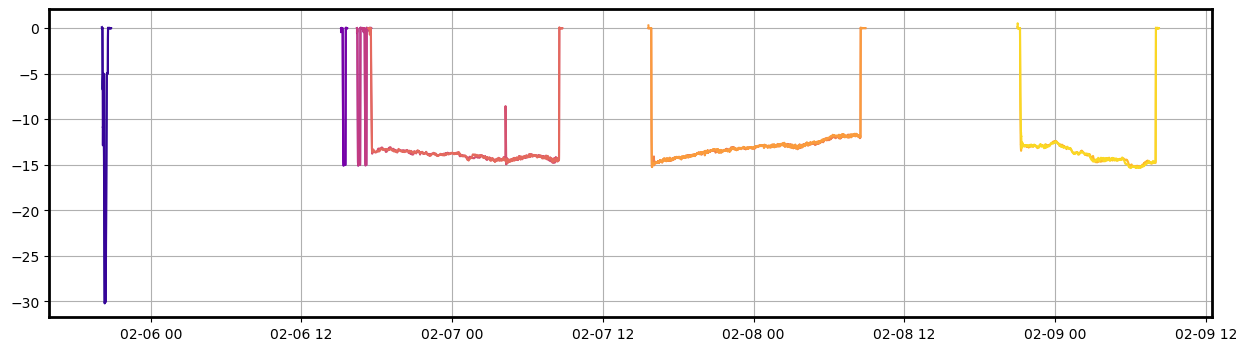

In [15]:
sb.plot_depth(Dc, legend=False)

### manually search for core deployment time periods for drift/scan experiments

In [16]:
sb.pprint(Dc)
#pprint(Dt)

test_guerledan_2024_02_05 / seabot4 2024/02/05 20:06:44 to 2024/02/05 20:50:17
test_guerledan_2024_02_05 / seabot5 2024/02/05 20:06:57 to 2024/02/05 20:50:09
test_guerledan_2024_02_06 / test_15m / seabot1 2024/02/06 15:11:40 to 2024/02/06 15:37:41
test_guerledan_2024_02_06 / test_15m / seabot3 2024/02/06 15:08:47 to 2024/02/06 15:37:44
test_guerledan_2024_02_06 / test_emission_inter_flotteur / seabot1 / rosbag2_2024_02_06-16_25_01 2024/02/06 16:25:01 to 2024/02/06 16:45:17
test_guerledan_2024_02_06 / test_emission_inter_flotteur / seabot1 / rosbag2_2024_02_06-16_57_08 2024/02/06 16:57:08 to 2024/02/06 17:33:15
test_guerledan_2024_02_06 / test_emission_inter_flotteur / seabot3 2024/02/06 16:25:35 to 2024/02/06 17:26:17
test_guerledan_2024_02_07 / night / seabot4 2024/02/06 17:20:19 to 2024/02/07 08:45:10
test_guerledan_2024_02_07 / night / seabot5 2024/02/06 17:20:34 to 2024/02/07 08:45:35
test_guerledan_2024_02_08 / night / seabot4 2024/02/07 15:37:16 to 2024/02/08 08:53:00
test_guerle

In [17]:
key = list(Dc)[8]
print(key)
df = Dc[key]

#(df["depth"].hvplot(grid=True)+df["velocity"].hvplot(grid=True)).cols(1)

('test_guerledan_2024_02_07', 'night', 'seabot5')


In [18]:
# select drift or scan period
Dcore = {}
for plabel, p in cp.platforms.items():
    for d in p["deployments"]:
        if "isoT" in d or "scan" in d:
            #cp["seabot4"]["drift0"]["iso_start"]
            print(plabel,d)
            key = M[(plabel, d)]
            if key in Dc:
                Dcore[key] = Dc[key].loc[cp[plabel][d]["iso_start"]:cp[plabel][d]["iso_end"]]

seabot4 isoT0
seabot4 isoT1
seabot4 isoT2
seabot5 isoT0
seabot5 isoT1
seabot5 isoT2


In [19]:
# mask bad parts:
Ma = None
if cp["name"]=="guerledan_202402":
    Ma = {
        ('test_guerledan_2024_02_07', 'night', 'seabot4'):slice("2024/02/07 04:13:30","2024/02/07 04:18:00"),
    }
if Ma is not None:
    for m in Ma:
        df = Dcore[m]
        Dcore[m] = df.loc[ (df.index<Ma[m].start) | (df.index>Ma[m].stop) ]

In [20]:
p = None
if show_hv:
    p = (sb.hv_plot(Dcore, "ka_depth", revert_yaxis=True) 
     + sb.hv_plot(Dcore, "te_temperature")
     + sb.hv_plot(Dcore, "ka_velocity") 
    ).cols(1)
p

In [21]:
# compare kalman and observer depth
p=None
if show_hv:
    p = (sb.hv_plot(Dk, "depth") * sb.hv_plot(Dd, "depth")).opts(invert_yaxis=True)
p

---
## inspect, extract and store vertical profiles of stratification

### extract profile time interval

In [22]:
p, d = 'seabot4', "cast0"
#p, d = 'seabot5', "cast0"
m = M[(p, d)]

df = (
    Dc[m][["te_temperature", "ka_depth"]]
    .copy()
    .rename(columns=dict(te_temperature="temperature", ka_depth="depth"))
)
df.lon, df.lat = sb.g_lon, sb.g_lat
df["salinity"] = 0.

In [23]:
if show_hv:
    df.sw.plot_bokeh(deployments=cp[p][d], cross=False)

### loop over casts and store vertical profile

In [24]:
prod = False

P = {}
for p, _p in cp.platforms.items():
    for d in _p["deployments"]:
        
        nc = os.path.join(cp["path_processed"], f'{p}_{d}.nc')
        
        if "cast" in d:
        
            if prod:
                #p, d = 'seabot5', "cast0"
                m = M[(p, d)]

                df = (
                    Dc[m][["temperature", "depth"]]
                    .copy()
                    .rename(columns=dict(te_temperature="temperature", ka_depth="depth"))
                )
                df = df.ts.trim(cp[p][d])

                df.lon, df.lat = sb.g_lon, sb.g_lat
                df["salinity"] = 0.

                dfp = df.sw.compute_vertical_profile(0.5)
                dsp = dfp.to_xarray()
                
                # store
                P[f'{p}_{d}'] = dsp
                dsp.to_netcdf(nc, mode="w")
            else:
                
                P[f'{p}_{d}'] = xr.open_dataset(nc)

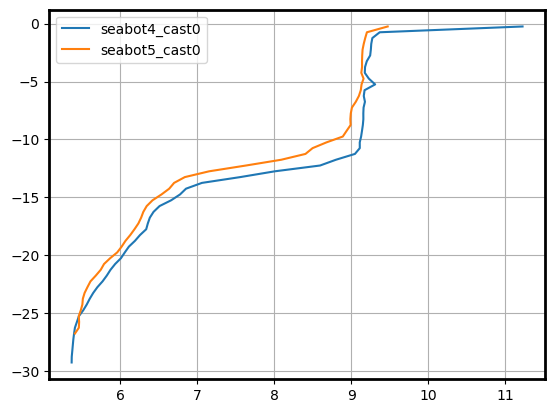

In [25]:
fig, ax = plt.subplots(1,1)
for c, df in P.items():
    ax.plot(df["temperature"], df.z, label=c)
ax.legend()
ax.grid()

In [26]:
if cp["name"]=="guerledan_202310":
    dTdz = 1.2 # degC/m # 2023/10
elif cp["name"]=="guerledan_202402":
    dTdz = 1. # degC/m # 2024/02

In [27]:
# instantiate float object
f = fl.autonomous_float(model='seabot')
f.init_piston()
f.piston.update_d(5e-2)

ds = P["seabot4_cast0"]
w = fl.waterp(**{v: ds[v].values for v in ["temperature", "salinity", "pressure"]}, lon=sb.g_lon, lat=sb.g_lat)

# check drag consistent with interns' report:
u = .3 # m/s
print(f"Drag force in Newton for u = {u:.2f} m/s: ", -f["m"]*f.get_cd(u, 0.)*u) # drag in Newtons

Piston max volume set from max displacement
Drag force in Newton for u = 0.30 m/s:  -0.6299713199999999


-270.7 g  were added to the float in order to be at equilibrium at 15 dbar 



(174.75, 174.9474408967816)

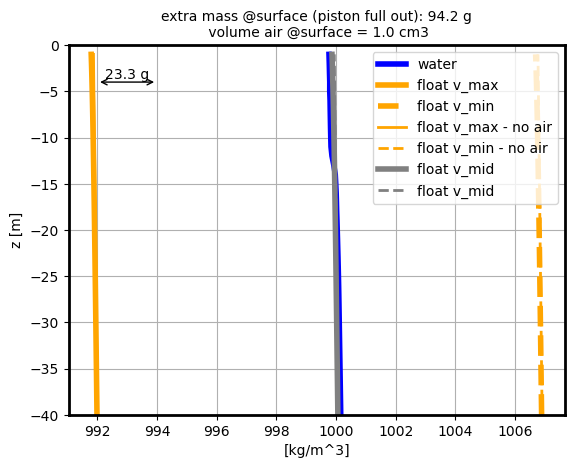

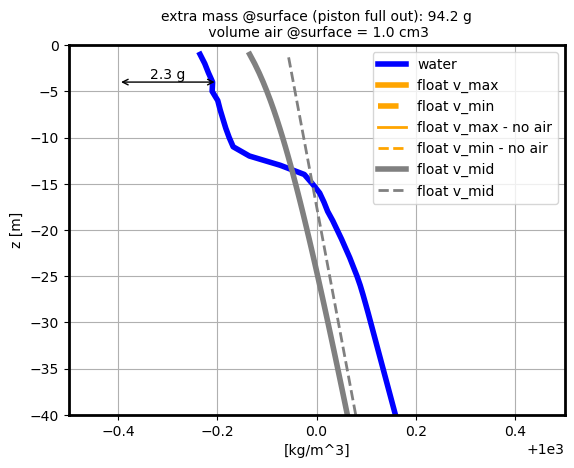

In [28]:
# adjust mass to target one depth
z_equilibrium = -15.
_w = w.at(z=z_equilibrium, extra=True)
rho_w, p, temp, N2 = _w["rho"], _w["pressure"], _w["temperature"], _w["N2"]
f.adjust_m(p,temp,rho_w, offset=0.)

# plot 
z=np.arange(-40.,0.,1.)
ax = fl.plot_float_density(z, f, w, v_air=1*fl.cm3, mid=f.piston.vol, show_no_air=True) #, xlim=(999, 1001))
ax = fl.plot_float_density(z, f, w, v_air=1*fl.cm3, mid=f.piston.vol, show_no_air=True, xlim=(999.5, 1000.5))

# check full volume change available
7.5*23.3, 11e-2*f.piston.A*1000e3 # g

In [29]:
# base case: depth dependance + at a single depth
H = f.get_transfer_functions(w, 1e-3, (-4, -2), v_air=fl.cm3*0., Ap=f.piston.A)
H1 = f.get_transfer_functions(w, 1e-3, (-4, -2), v_air=fl.cm3*1., Ap=f.piston.A)
H10 = f.get_transfer_functions(w, 1e-3, (-4, -2), v_air=fl.cm3*10., Ap=f.piston.A)

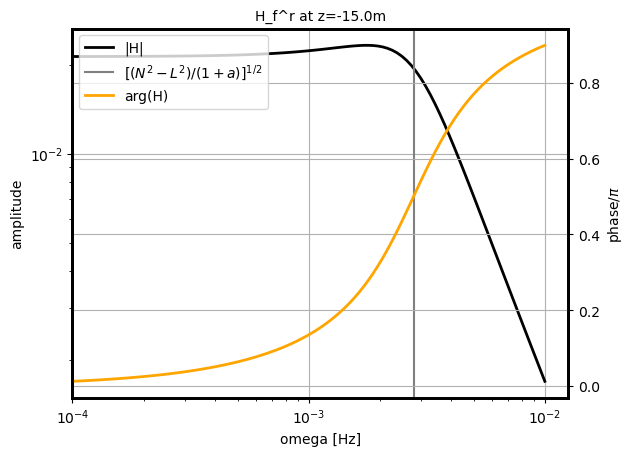

In [30]:
Heq = H.sel(z=-13, method="nearest")

#H_label = "H_w^f"
H_label = "H_f^r"
#H_label = "H_p^rbis" # looks about the same
da = Heq[H_label]
#dab = Heq["H_w^r"]

fig, ax = plt.subplots(1,1)

h0 = ax.plot(da.omega, np.abs(da), 'k', lw=2, label="|H|")
#h0b = ax.plot(da.omega, np.abs(dab), 'b', lw=2, label="|H|")
h1 = ax.axvline(np.sqrt((Heq.N2)/(1+f.a))/2/np.pi, color="0.5", ls="-", label=r"$[(N^2-L^2)/(1+a)]^{1/2}$")
#ax.axvline(np.sqrt((Heq.N2-Heq.L2)/(1+f.a))/2/np.pi, color="0.5", ls="--")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title(f"{H_label} at z={z_equilibrium:.1f}m")
ax.set_xlabel("omega [Hz]")
ax.set_ylabel("amplitude")

axp = ax.twinx()
angles = np.unwrap(np.angle(da))/np.pi
h2 = axp.plot(da.omega, angles, 'orange', lw=2, label="arg(H)")
ax.grid()
axp.grid()
axp.set_ylabel(r"phase/$\pi$")

ax.set_xlim(1e-4, None)

axp.legend(handles=[h0[0], h1, h2[0]], loc=2)

Text(0.5, 1.0, 'mean(M2-N2+L2)=1.32e-05')

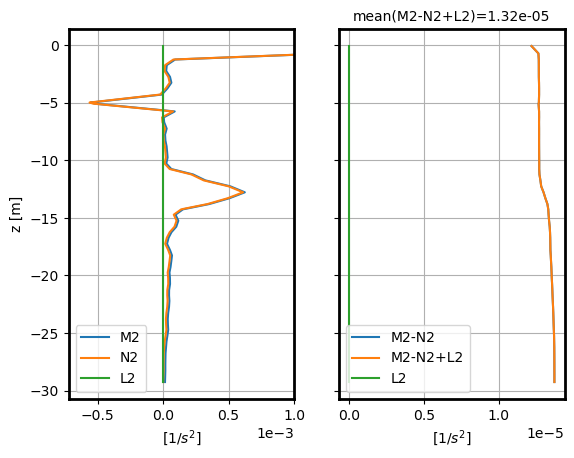

In [31]:
fig, axes = plt.subplots(1,2, sharey=True)

ax = axes[0]
ax.plot(H.M2, H.z, label="M2")
ax.plot(H.N2, H.z, label="N2")
ax.plot(H.L2, H.z, label="L2")
ax.legend()
ax.ticklabel_format(axis='x', scilimits=[-3, 3])
ax.grid()
ax.set_ylabel("z [m]")
ax.set_xlabel(r"$[1/s^2]$")
ax.set_xlim(None,1e-3)

ax = axes[1]
ax.plot(H.M2-H.N2, H.z, label="M2-N2")
ax.plot(H.M2-H.N2+H.L2, H.z, label="M2-N2+L2")
ax.plot(H.L2, H.z, label="L2")
#ax.plot(f, H.z, label="L2")
ax.legend(loc=3)
ax.grid()
ax.set_xlabel(r"$[1/s^2]$")
_mean = (H.M2-H.N2+H.L2).mean()
ax.set_title(f"mean(M2-N2+L2)={_mean:.2e}")

(-0.0011004470415511025, 0.001)

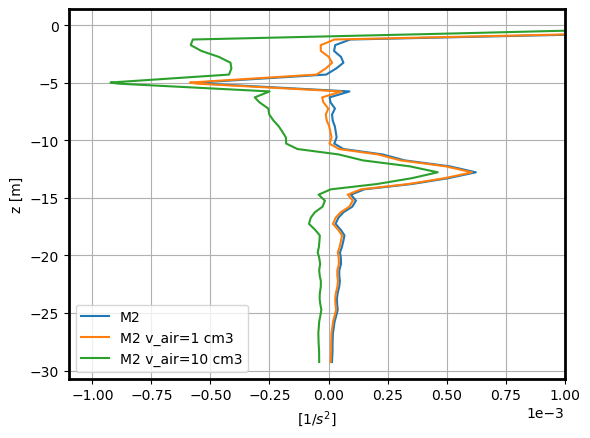

In [32]:
fig, axes = plt.subplots(1,1, sharey=True)

ax = axes
ax.plot(H.M2, H.z, label="M2")
ax.plot(H1.M2, H.z, label="M2 v_air=1 cm3")
ax.plot(H10.M2, H.z, label="M2 v_air=10 cm3")
ax.legend()
ax.ticklabel_format(axis='x', scilimits=[-3, 3])
ax.grid()
ax.set_ylabel("z [m]")
ax.set_xlabel(r"$[1/s^2]$")
ax.set_xlim(None,1e-3)

The natural stability of the float is governed by the sign of $M^2$ which depends on the amount of trapped air.

---

## isotherm following missions

In [33]:
iso_T = []
for plabel, p in cp.platforms.items():
    for d in p["deployments"]:
        if "isoT" in d:
            print(plabel,d)
            iso_T.append(M[(plabel, d)])

seabot4 isoT0
seabot4 isoT1
seabot4 isoT2
seabot5 isoT0
seabot5 isoT1
seabot5 isoT2


In [34]:
# buid dataset with isothermal displacement

Diso = {}
for d in iso_T:
    
    df = Dcore[d]
    
    #df["depth_anomaly"] = df["depth"] - df["depth"].mean()
    df["depth_anomaly"] = df["depth_filtered"] - df["depth_filtered"].mean()   # -z_f
    dt = (df.reset_index()["time"].diff().bfill() / pd.Timedelta("1s")).values
    df["velocity_float"] = df["depth_anomaly"].diff().bfill().values / dt   # -dz_f/dt, should be close to "velocity"
    
    if "te_temperature" in df:
        df["temperature_anomaly"] = df["te_temperature"] - df["te_temperature"].mean()

        df["relative_displacement"] = df["temperature_anomaly"]/dTdz  # -(z_w-z_f)
        df["isotherm_displacement"] = df["relative_displacement"] + df["depth_anomaly"]    # -z_w
        # positive downwards
        # compensates for the float vertical displacement

        #df["temperature_rate_of_change"] =  (df["temperature"].diff()).bfill()

        # compute estimated
        #df["velocity_water"] = -df["temperature_rate_of_change"]/dTdz - df["velocity"]    
        df["velocity_water"] = df["isotherm_displacement"].diff().bfill().values / dt      # -dz_w/dt
        df["velocity_relative"] = df["relative_displacement"].diff().bfill().values / dt   # -dz_r/dt
        
    df["pi_course_anomaly"] = df["pi_course"] - df["pi_course"].mean()
    
    Diso[d] = df

### global metrics of regulation

In [35]:
def plot_hist(D, v, bins, unit):

    fig, axes = plt.subplots(2, 3, figsize=(7,4), sharex=True, sharey=True)

    i = 0
    for d in list(D):
        df = D[d]
        ax = axes.T.flatten()[i]
        if v in df:
            df[v].plot.hist(
                ax=ax, bins=bins, density=True, 
                color=colors[d], 
                #label=" - ".join(d), #+df.index[0].strftime("%Y/%m/%d %H:%M")
            )
            std = df[v].std()
            ax.text(0.1, 0.9, f"std = {std:.2e} {unit}", size=8, transform=ax.transAxes)
        ax.grid()
        ax.set_title(sb.key2title(d, " "))
        if i%2==1:
            ax.set_xlabel(f"[{unit}]")
        i+=1

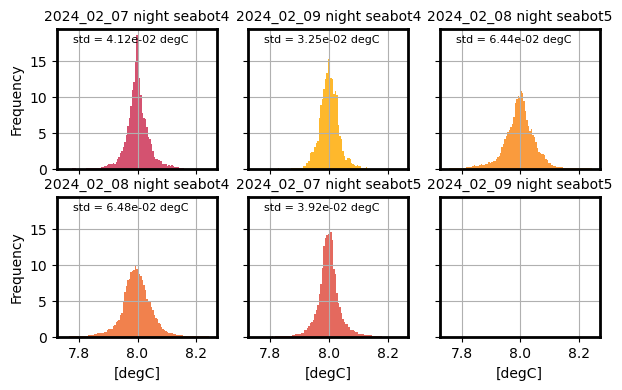

In [36]:
#bins = np.arange(13.8, 14.2, .005) # 2023/10
bins = np.arange(7.75, 8.25, .005) # 2024/02
plot_hist(Diso, "te_temperature", bins, "degC")        

not bad ... 😁 We must be close to instrument relative accuracy

Question is what controls these fluctuations (intrumental noise vs high frequency fluctuations)

0.05 degC in a 0.5 degC/m thermal gradient is equivalent to a 10 cm vertical displacement

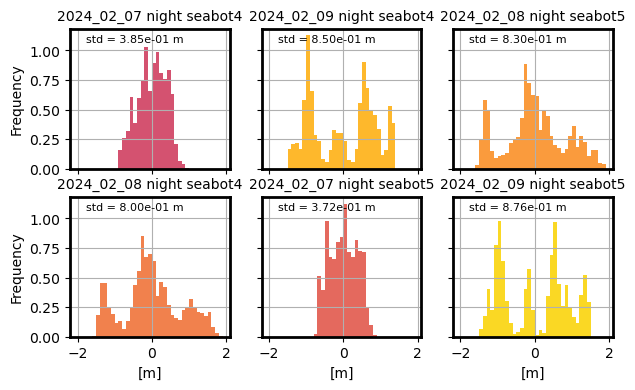

In [37]:
#bins = np.arange(13.8, 14.2, .005) # 2023/10
bins = np.arange(-2., 2., .1) # 2024/02
plot_hist(Diso, "depth_anomaly", bins, "m") # - z_f

2024/02: vertical displacements are meters like

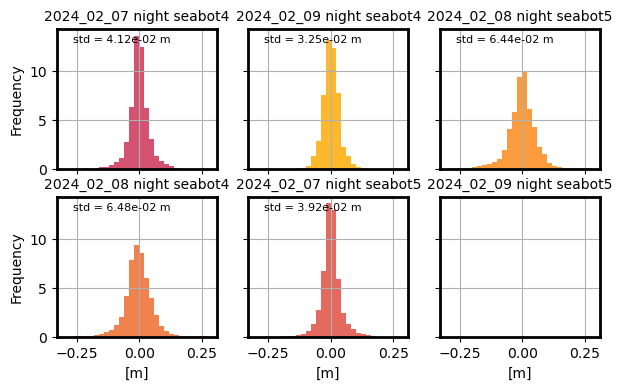

In [38]:
#bins = np.arange(13.8, 14.2, .005) # 2023/10
bins = np.arange(-.3, .3, .02) # 2024/02
plot_hist(Diso, "relative_displacement", bins, "m") # -(z_w-z_f)

2024/02: displacements relative to isotherms are about 5 cm (as expected), which is smaller than the float displacement and indicates the float successfully follows isotherms

2023/10: (to be verified) 2-3 cm is less that the vertical displacement (see next diagnostics) which confirms that depth variations do indeed reflect isotherm displacements

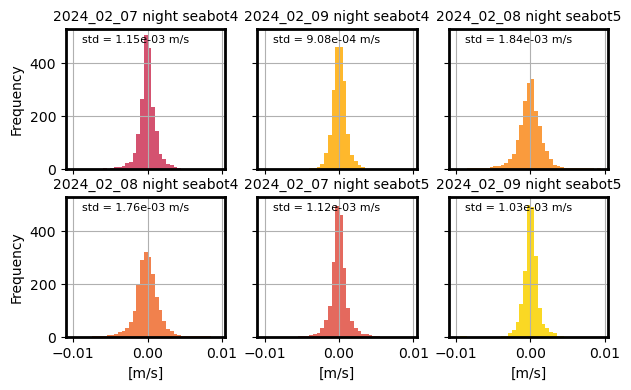

In [39]:
#bins = np.arange(13.8, 14.2, .005) # 2023/10
bins = np.arange(-.01, .01, .0005) # 2024/02
plot_hist(Diso, "ka_velocity", bins, "m/s")
# plot_hist(Diso, "velocity_float", bins, "m/s") # very similar, as expected

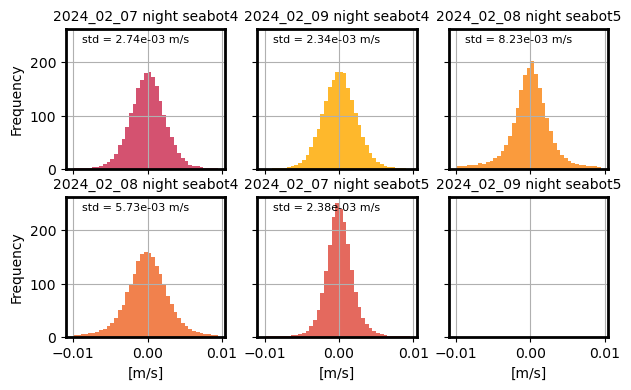

In [40]:
plot_hist(Diso, "velocity_water", bins, "m/s")

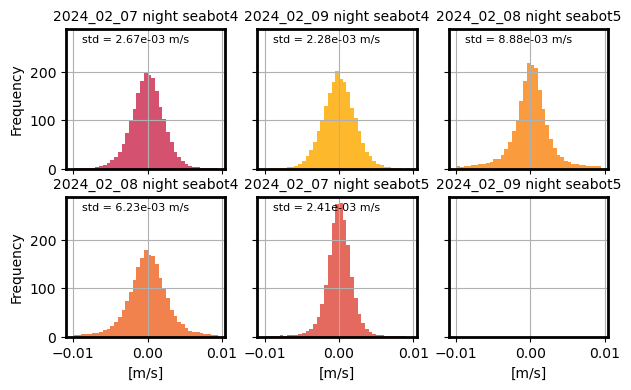

In [41]:
plot_hist(Diso, "velocity_relative", bins, "m/s")

- Velocities diagnostics emphasize higher frequencies where the float does not follow isotherms.
- Float velocity is about 1mm/s and up to 9 times smaller than water velocity estimates and relative velocities. This means the float moves little but observe temperature fluctuations corresponding to larger displacements of the water column.

### time series

In [42]:
key = iso_T[3]
df = Diso[key]
print(key)

# for latter comparison
df["depth_difference"] = df["ka_depth"] - df["de_depth"]

# show mean depth, temperature for this deployment
df["ka_depth"].mean(), df["te_temperature"].mean()

('test_guerledan_2024_02_07', 'night', 'seabot5')


(13.95416313484656, 7.999783603109935)

In [43]:
# not that this works at low-frequencies (compare to M, i.e. 2e-3 Hz - 500s = 8 min )
course2displacement = -9.81*f.piston.A/f["V"]/float(Heq.M2)

p=None
if show_hv:
    p = (
        (df["pi_course_anomaly"]*course2displacement).rename("piston induced displacement").hvplot()
        +
        (
            df["depth_anomaly"].hvplot(grid=True) 
            * df["isotherm_displacement"].hvplot() 
            * (df["relative_displacement"]).hvplot()
            #* (df["pi_course_anomaly"]*course2displacement).rename("piston induced displacement").hvplot()
        )
        +
        (
            df["ka_velocity"].hvplot(grid=True)
            * df["velocity_water"].hvplot()
            * df["velocity_relative"].hvplot()
        )
    ).cols(1)
p

The float is able to follow low-frequency (> minutes) fluctuations but not higher frequency temperature fluctuations.
This limit may be related to the float natural dynamics and/or regulation response parameters (relaxation feedback constants).

Note that for 5 minutes (0.003 Hz) fluctuations of isotherms, there is a lag of about 50 seconds with the float response but piston displacements do seem heratic (**show Thomas**).

Because of the temperature sensor, we can in theory compensate for this inability to follow isotherm.
This should thus be non-blocking for oceanographic applications.
This is provided internal waves are not "breathing" (dilating stratification).

The vertical velocity associated with high frequency isothermal displacement is about 50 cm / 3 min = 3 mm/s

### compute spectra

In [44]:
E = (
    df[
        ['ka_depth', 'ka_velocity',
         'depth_anomaly', 'temperature_anomaly',
         'relative_displacement', 'isotherm_displacement',
         'velocity_water', 'velocity_relative',
         'pi_course',
         'depth_difference', 'de_depth',
        ]
    ]
    .ts.spectrum(unit="1s", nperseg="2H")
    .to_xarray()
)
E = E.where(E.frequency>0, drop=True)
E.frequency.attrs.update(units="Hz")

In [45]:
# base case: depth dependance + at a single depth
He = f.get_transfer_functions(w, 1e-3, E.frequency.values, v_air=fl.cm3*1., Ap=f.piston.A)
He = He.rename(omega="frequency")
He = He.sel(z=-14, method="nearest")

In [46]:
# util
def _add_labels(ax):
    # buoyancy frequency
    #N = np.sqrt( 9.81 * 2e-4 * dTdz )
    N = np.sqrt(float(He.N2))
    print(f"Buoyancy period = {2*np.pi/N/60:.1f} min")
    ax.axvline(N/2/np.pi, color="k", ls="--")
    ax.text(N/2/np.pi, -.05, 'N', transform=ax.get_xaxis_transform(), ha='center', va='top')
    ax.axvline(1/3600, color="k", ls="--")
    ax.text(1/3600, -.05, '1h', transform=ax.get_xaxis_transform(), ha='center', va='top')

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_ylim(1e-11, 1e4)

    ax.grid()
    ax.legend()
    ax.set_title("")

Buoyancy period = 5.7 min


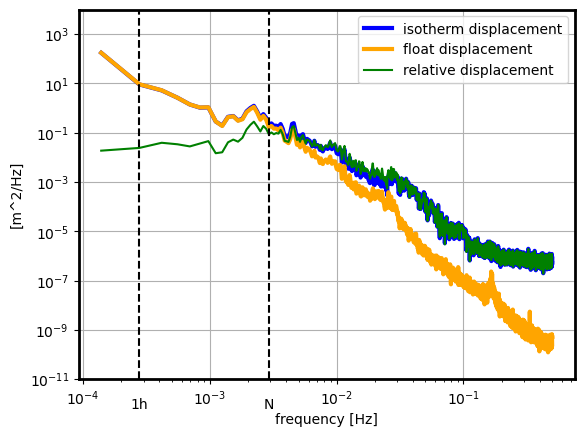

In [47]:
fig, ax = plt.subplots(1,1) #, figsize=(5,7))

E["isotherm_displacement"].plot(ax=ax, c="b", lw=3, label="isotherm displacement")
E["depth_anomaly"].plot(ax=ax, lw=3, c="orange", label="float displacement")
E["relative_displacement"].plot(ax=ax, c="g", label="relative displacement")

_add_labels(ax)
ax.set_ylabel("[m^2/Hz]");

- at low frequency, float displacements match that of isotherms and relative displacements are weak.
- at high frequencies, the float follows less isotherms. This is not expected from theory. Two potential reasons: effect of regulation or failure of theory (e.g. waves spatially smaller than the float)

Buoyancy period = 5.7 min


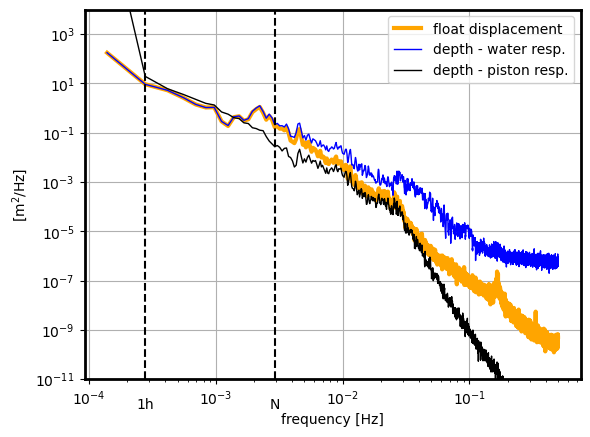

In [48]:
fig, ax = plt.subplots(1,1) #, figsize=(5,7))

#E["isotherm_displacement"].plot(ax=ax, c="b", lw=3, label="isotherm displacement")
E["depth_anomaly"].plot(ax=ax, lw=3, c="orange", label="float displacement")
#E["relative_displacement"].plot(ax=ax, c="g", label="relative displacement")

#E["isotherm_displacement_natural"] = E["depth_anomaly"] / np.abs(He["H_w^f"])**2
#E["isotherm_displacement_natural"].plot(ax=ax, c="b", lw=1, ls="--", label="isotherm displacement - natural")
E["depth_w"] = E["isotherm_displacement"] * np.abs(He["H_w^f"])**2
E["depth_w"].plot(ax=ax, c="b", lw=1, ls="-", label="depth - water resp.")

E["depth_p"] = E["pi_course"] * np.abs(He["H_p^r"])**2
E["depth_p"].plot(ax=ax, c="k", lw=1, ls="-", label="depth - piston resp.")

_add_labels(ax)
ax.set_ylabel("[m$^2$/Hz]");

- at low frequencies, water motions and piston displacements may equally explain float displacements
- around N, the float moves more than what may be attributed to piston displacements and the float is likely being moved by water motions
- at higher frequencies, the piston may be responsible for dispklacements up until frequencies of about 0.03 Hz (30s) where the effect of the piston drops sharply.

**Should we try to estimate transfer functions and compare them with theoretical ones ?**

Buoyancy period = 5.7 min


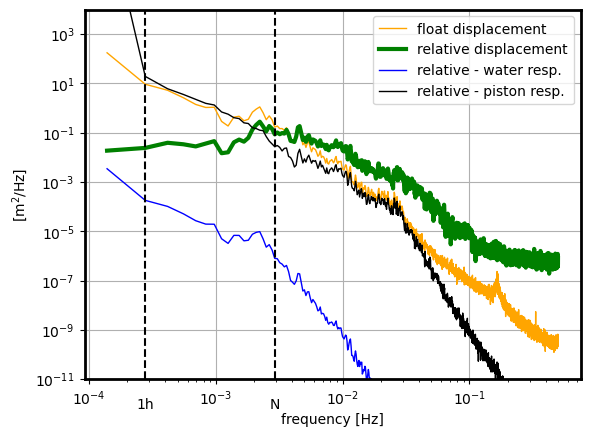

In [49]:
fig, ax = plt.subplots(1,1) #, figsize=(5,7))

E["depth_anomaly"].plot(ax=ax, lw=1, c="orange", label="float displacement")
E["relative_displacement"].plot(ax=ax, lw=3, c="g", label="relative displacement")

E["relative_w"] = E["isotherm_displacement"] * np.abs(He["H_w^r"])**2
E["relative_w"].plot(ax=ax, c="b", lw=1, ls="-", label="relative - water resp.")

E["relative_p"] = E["pi_course"] * np.abs(He["H_p^r"])**2
E["relative_p"].plot(ax=ax, c="k", lw=1, ls="-", label="relative - piston resp.")

_add_labels(ax)
ax.set_ylabel("[m$^2$/Hz]");

- relative motions have a flat spectrum up until about 0.01 Hz (100s) where it starts decaying with frequency.
- theory and inferred isotherm displacements predict relative displacements much weaker than those actually observed. This may be explained by the effect of the piston and/or and/or failure at estimating isotherm displacements and/or failure of theory. Piston displacements should induce larger relative displacements than those actually observed (??? bug in estimation of the reponse to water motions?).
- starting at N and provided estimates of the relative displacement is accurate, the piston cannot explain observed relative displacements and is therefore unlikely responsible for thoses

Buoyancy period = 5.7 min


(1e-20, 1e-05)

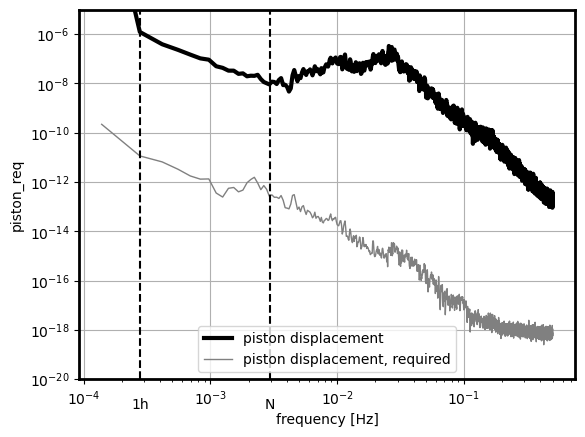

In [50]:
fig, ax = plt.subplots(1,1) #, figsize=(5,7))

E["pi_course"].plot(ax=ax, lw=3, c="k", label="piston displacement")
#E["relative_displacement"].plot(ax=ax, lw=3, c="g", label="relative displacement")

E["piston_req"] = E["isotherm_displacement"] * np.abs(He["H_w^r"]/He["H_p^r"])**2
E["piston_req"].plot(ax=ax, c="0.5", lw=1, ls="-", label="piston displacement, required")

_add_labels(ax)
#ax.set_ylabel("[m$^2$/Hz]");
ax.set_ylim(1e-20, 1e-5)

- if theory holds, the piston is moving much more than what is required to hold an isothermal behavior

Buoyancy period = 5.7 min


(1e-10, 0.1)

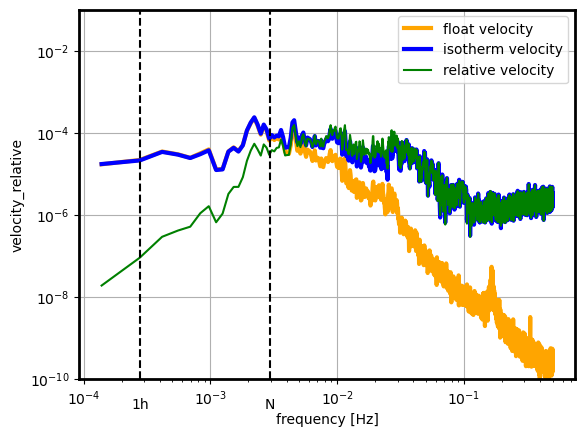

In [51]:
fig, ax = plt.subplots(1,1)

E["ka_velocity"].plot(ax=ax, color="orange", lw=3, label="float velocity")
E["velocity_water"].plot(ax=ax, color="b", lw=3, label="isotherm velocity")
E["velocity_relative"].plot(ax=ax, color="g", label="relative velocity")

_add_labels(ax)
#ax.set_ylabel("[m$^2$/Hz]");
ax.set_ylim(1e-10, 1e-1)

Kalman depth vs raw depth

Buoyancy period = 5.7 min


(1e-09, 10000.0)

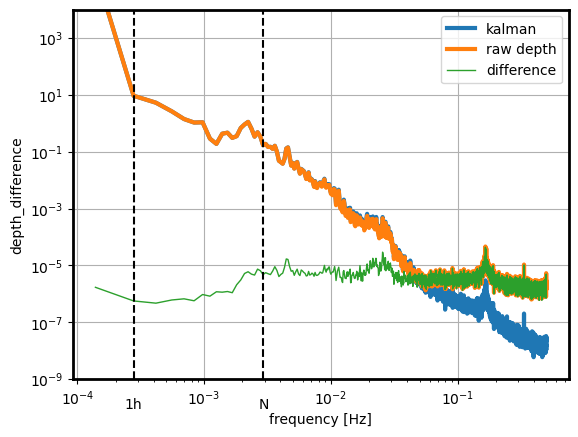

In [52]:
fig, ax = plt.subplots(1,1)

E["ka_depth"].plot(ax=ax, lw=3, label="kalman")
E["de_depth"].plot(ax=ax, lw=3, label="raw depth")
E["depth_difference"].plot(ax=ax, lw=1, label="difference")
#E["velocity_relative"].plot(ax=ax, color="g", label="relative velocity")

_add_labels(ax)
#ax.set_ylabel("[m$^2$/Hz]");
ax.set_ylim(1e-9, 1e4)

The noise floor starts at 0.05 Hz (20 seconds)

---

## dynamical equation reconstruction

- level 0: $z_f$, water motions left as residual
- level 1: $z_r$ (with uncertainty around relation motion estimations)

In [53]:
# init eos to get density
import gsw

df['depth'] = df['ka_depth']
df['velocity'] = df['ka_velocity']
df['temperature'] = df['te_temperature']
df['salinity'] = 0.
df['lon'], df['lat'] = sb.g_lon, sb.g_lat
df.sw.init()
df["rho_water"] = gsw.density.rho(df.SA, df.CT, df.pressure)

some values of longitude and latitudes are NaN, you may want to fill in with correct values


In [54]:
ds = df[["velocity", "depth", "pi_volume", "rho_water"]].to_xarray()

# estimate acceleration
ds["acceleration"] = ds["velocity"].differentiate("time", datetime_unit="1s")
ds["dyn_acceleration"] = -(1+f["a"])*ds["acceleration"]

# estimate drag
ds["c_d"] = f.get_cd(-ds["velocity"], 0.)
ds["dyn_drag"] = -ds.c_d * ds["velocity"]

# estimate buoyancy force: linearized, with piston
g = 9.81

# this what we do if we didn't know temperature and it would be wrong because 
# it would not faithfully account for density of surrounding water
#_w = w.at(z=ds["depth"])
#ds["rho_water"] = _w["rho"]
# if we use temperature instead

ds["rho_f"] = f.rho(z=-ds["depth"], waterp=w)
#rho_ref = f["m"]/f["V"]
rho_w_mean = ds["rho_water"].mean()
rho_f_mean = ds["rho_f"].mean()
ds["dyn_buoy_water"] = -g*(ds["rho_water"]-rho_w_mean)/rho_f_mean
ds["dyn_buoy_float"] =  g*(ds["rho_f"]-rho_f_mean)/rho_f_mean
ds["dyn_buoy_piston"] = -g*ds["pi_volume"]/f["V"]

# estimate residual
def add_residual(ds):
    ds["dyn_residual"] = (
        ds["dyn_acceleration"] + ds["dyn_drag"] 
        + ds["dyn_buoy_water"] + ds["dyn_buoy_float"] + ds["dyn_buoy_piston"]
    )
# enforce null average
add_residual(ds)
ds["dyn_buoy_piston"] = ds["dyn_buoy_piston"] - ds["dyn_residual"].mean()
add_residual(ds)

dyn = [
    "dyn_acceleration", "dyn_drag", 
    "dyn_buoy_water", "dyn_buoy_float", "dyn_buoy_piston",
    "dyn_residual",
]


In [ ]:
_df = ds[dyn].to_dataframe()
_df.drop(columns=["z", "z_bg"]).hvplot(title="dynamical reconstruction [m/s2]")

In [56]:
_a = 1e-3
_v = _a * f.V/g /fl.cm3 
print(f"an acceleration of {_a:.0e} m/s^2 corresponds to a volume difference of {_v:.02f} cm3")

an acceleration of 1e-03 m/s^2 corresponds to a volume difference of 1.19 cm3


Drag may be exagerated if the float follows isotherms (as it is to some extent the case for 5 min buoyancy oscillations).

---

## temperature delay - to be updated

#### 1. simple offset on temperature: 

Seems to work within the water column but not at deepest levels nor at the surface

In [ ]:
key = list(Dc)[1]
print(key)
df = Dc[key]

fig, ax = plt.subplots(1,1)

delays = ["0s", "-2s", "-4s"]
_colors = pin.get_cmap_colors(len(delays))

for delay, c in zip(delays, _colors):
    _df = df.copy()
    _df["temperature"] = _df["temperature"].shift(freq=delay) # avance
    #_df.plot.scatter("temperature","depth", s=1, c=c, ax=ax, label=delay)
    ax.plot(_df.temperature, _df.depth, color=c, label=delay)

ax.invert_yaxis()
ax.grid()
ax.legend()
ax.set_xlim(None,10)

#### 2. low-pass filter depth instead

seems to behave similarly, 2s seconds seems a reasonable choice

In [ ]:
df = DF[0]

fig, ax = plt.subplots(1,1)

taus = [2, 3, 4]
_colors = pin.get_cmap_colors(len(taus))

for tau, c in zip(taus, _colors):
    _df = df.copy()
    append_depth_filtered(_df, tau)
    ax.plot(_df.temperature, _df.depth_filtered, label=f"tau={tau}")

ax.invert_yaxis()
ax.grid()
ax.legend()

---

## thermocline scanning experiment - to be updated

In [ ]:
def plot_scatter(df):

    fig, ax = plt.subplots(1,1, figsize=(10, 5))

    _df = df.reset_index()
    _df = _df.loc[_df.velocity>0] # downward profiles

    _df.plot.scatter("time", "depth_filtered", c="temperature", s=8, ax=ax, cmap=cm.thermal)
    ax.grid()

    ax.invert_yaxis()

#

In [ ]:
plot_scatter(DT[9])
plot_scatter(DT[11])

In [ ]:
# with hvplot

#df = DT[9]
#df = df.reset_index()
#df = df.loc[df.velocity>0] # select downward profiles

#_df.hvplot.scatter("time", "depth", c="temperature", s=10, ax=ax, cmap=cm.thermal).opts(invert_yaxis=True)

#### depth-time bin average

In [ ]:
def depth_time_bin_average(df, dz=.1, freq="10T", ascent=False):

    df = df.reset_index()
    if ascent is None:
        pass
    elif ascent:
        df = df.loc[df.velocity<0] # select downward profiles
    else:
        df = df.loc[df.velocity>0] # select downward profiles
        

    dbins = np.arange(15, 20.5, dz)
    tbins = pd.date_range(df.time.iloc[0], df.time.iloc[-1], freq=freq)

    #df["depth_cut"] = pd.cut(df["depth"], dbins)
    df["depth_cut"] = pd.cut(df["depth_filtered"], dbins)
    df["time_cut"] = pd.cut(df["time"], tbins)


    dfb = df.groupby(["depth_cut", "time_cut"]).mean().reset_index()

    dfb["depth"] = dfb["depth_cut"].apply(lambda i: i.left)
    dfb["time"] = dfb["time_cut"].apply(lambda i: i.left)

    ds = dfb.set_index(["depth", "time",]).to_xarray()

    return ds


def bin_plot(df, **kwargs):

    ds = depth_time_bin_average(df, **kwargs)

    fig, ax = plt.subplots(1,1)

    #DT[8]["depth"].plot(ax=ax, color="k")
    #DT[10]["depth"].plot(ax=ax, color="0.3")
    DT[8]["depth_filtered"].plot(ax=ax, color="k")
    DT[10]["depth_filtered"].plot(ax=ax, color="0.3")

    ds["temperature"].plot(ax=ax, cmap=cm.thermal)
    ds["temperature"].plot.contour(ax=ax, levels=[12, 14, 16], colors="w")

    ax.invert_yaxis()
    ax.grid()

In [ ]:
bin_plot(DT[9], ascent=None)
bin_plot(DT[9], ascent=True)
bin_plot(DT[9], ascent=False)

In [ ]:
bin_plot(DT[11])

---
## archived material ...

In [ ]:
df = DT[9]

_df = df.reset_index()
_df["mask"] = 0.
_df["mask"].where(_df.velocity>0, other=1., inplace=True)

_df["mask_cumsum"] = _df["mask"].cumsum()

_df["mask_cumsum"].hvplot()

In [ ]:
df = DT[9]

_df = df.reset_index()

_df = _df.loc[_df.velocity>0] # downward profiles

dt = _df["time"].diff()/pd.Timedelta("1T")
print("Time intervals in minutes:")
print(np.unique(dt))

#(_df["time"].diff()/pd.Timedelta("1s")).plot.hist(bins=np.arange(0,10,1), log=True) #.plot()

In [ ]:
_df = df.reset_index()

_df = _df.loc[_df.velocity>0] # downward profiles
_dt = _df["time"].diff()/pd.Timedelta("1T")
bottom = _df.loc[_dt>1]

_df = df.reset_index()
_df = _df.loc[_df.velocity<0] # downward profiles
_dt = _df["time"].diff()/pd.Timedelta("1T")
top = _df.loc[_dt>1]

In [ ]:
(df.reset_index()["depth"].hvplot()
 * bottom["depth"].hvplot() 
 * top["depth"].hvplot() 
)